In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

In [2]:
f = uproot.open("/home/users/hdhoang2001/cmssw/src/RecoTracker/LSTCore/standalone/debug.root")

In [3]:
tree = f["tree"].arrays(library="np")

In [4]:
res = np.concatenate(tree["t3_residual"])
isfake = np.concatenate(tree["t3_isFake"])
isperfect = np.concatenate(tree["t3_isPerfect"])
region = np.concatenate(tree["t3_region"])

In [5]:
res_fake = res[isfake==1]
res_75_99 = res[((1-isfake) & (1-isperfect))==1]
res_100 = res[isperfect==1]

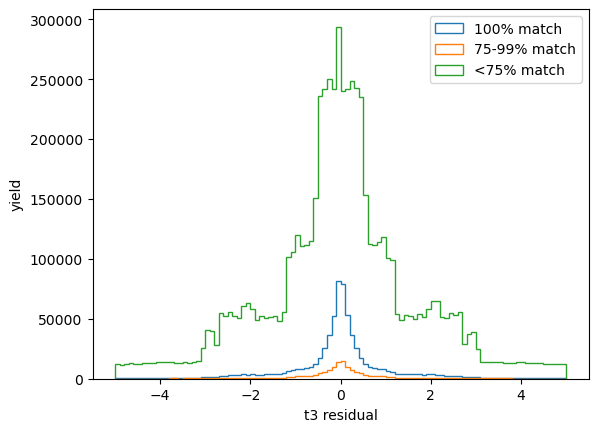

In [6]:
plt.hist(res_100, bins=100, histtype='step', label='100% match')
plt.hist(res_75_99, bins=100, histtype='step', label='75-99% match')
plt.hist(res_fake, bins=100, histtype='step', label='<75% match')
plt.xlabel('t3 residual')
plt.ylabel('yield')
plt.legend()
plt.show()

In [7]:
res_by_region = [res[region==i] for i in range(25)]
isfake_by_region = [isfake[region==i] for i in range(25)]
isperfect_by_region = [isperfect[region==i] for i in range(25)]

In [8]:
res_fake_by_region = [res_by_region[i][isfake_by_region[i]==1] for i in range(25)]
res_75_99_by_region = [res_by_region[i][((1-isfake_by_region[i]) & (1-isperfect_by_region[i]))==1] for i in range(25)]
res_100_by_region = [res_by_region[i][isperfect_by_region[i]==1] for i in range(25)]

In [9]:
for i in range(25):
    plt.hist(res_100_by_region[i], bins=100, histtype='step', label='100% match')
    plt.hist(res_75_99_by_region[i], bins=100, histtype='step', label='75-99% match')
    plt.hist(res_fake_by_region[i], bins=100, histtype='step', label='<75% match')
    plt.xlabel('t3 residual')
    plt.ylabel('yield')
    plt.legend()
    plt.savefig(f"t3_res_by_region/region_{i}.png")
    plt.clf()

<Figure size 640x480 with 0 Axes>